tensorboard --logidr=./show

In [34]:
number = ['0','1','2','3','4','5','6','7','8','9']
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
CHAR_NUM = len(number) + len(alphabet) + len(ALPHABET)

FLAG_CHAR = 1 # 0:fixed length; 1:variable lenght
CHAR_LEN = 4
MIN_CHAR_LEN = 4
MAX_CHAR_LEN = 6

IMAGE_HEIGHT = 60
IMAGE_WIDTH = 160

CHANNEL = 1

NUM_CNN_LAYERS = 4
CONV_FILTERS = 32
KERNEL_SIZE = 3
POOL_SIZE = 2
GRU_SIZE = 32

DROPOUT_RATE = 0.5

address_tensorboard = 'show/'
address_model = 'best_model.hdf5'

In [74]:
from captcha.image import ImageCaptcha
from PIL import Image
import random
import string

def get_char_length_and_number():
    if FLAG_CHAR == 0:
        char_len = CHAR_LEN
        char_num = CHAR_NUM
    elif FLAG_CHAR == 1:
        char_len = MAX_CHAR_LEN
        char_num = CHAR_NUM + 1
    else:
        raise ValueError(u'FLAG_CHAR should be 0 or 1')
        char_len = -1
    return char_len,char_num
    
def make_rand_char():
    return random.choice(string.ascii_letters+'0123456789')

def make_rand_text(length):
    text = ''
    for i in range(length):
        rand_char = ''
        r_char = make_rand_char()
        rand_char += r_char
        text += rand_char
    return text

def make_rand_image(text):
    image = ImageCaptcha()
    image = Image.open(image.generate(text))
    return image

def char2pos(c):
    if c >= '0' and c <= '9':
        k = ord(c) - ord('0')
    elif c >= 'a' and c <= 'z':
        k = ord(c) - ord('a') + 10
    elif c >= 'A' and c <= 'Z':
        k = ord(c) - ord('A') + 36
    elif c == '' or c == ' ':
        k = 62
    else:
        print ('character not in lists')
    return k

def pos2char(char_idx):
    if char_idx == -1:
        char = ''
    elif char_idx == 62:
        char = ''
    elif char_idx < 10:
        char = chr(int(char_idx + ord('0')))
    elif char_idx < 36:
        char = chr(int(char_idx - 10 + ord('a')))
    elif char_idx < 62:
        char = chr(int(char_idx - 36 + ord('A')))
    else:
        raise ValueError('error')
    return char

def text2index(text):
    index = []
    for i in text:
        text_index = char2pos(i)
        index.append(text_index)
    return index

def index2text(vec):
    text = ''
    for i in vec:
        char_code = pos2char(i)
        text += char_code
    return "".join(text)

def text2vec(text):
    text_len = len(text)
    char_len,char_num = get_char_length_and_number()
    
    if text_len > char_len:
        raise ValueError(u'Text length does not fit')

    vector = np.zeros(char_len * char_num)
    for i in range(char_len):
        if i < text_len:
            idx = i * char_num + char2pos(text[i])
        else:
            idx = i * char_num + char2pos('')
        vector[idx] = 1        
    return vector

def vec2text(vec):
    char_len,char_num = get_char_length_and_number()
    char_pos = vec.nonzero()[0]
    text = []
    for i, c in enumerate(char_pos):
        char_at_pos = i  # c/63
        char_idx = c % char_num
        char_code = pos2char(char_idx)
        text.append(char_code)
    return "".join(text)

def draw_vec2text(vec):
    char_len,char_num = get_char_length_and_number()
    char_pos = vec.nonzero()[1]
    text = []
    for i, c in enumerate(char_pos):
        char_at_pos = i  # c/63
        char_idx = c % char_num
        char_code = pos2char(char_idx)
        text.append(char_code)
    return "".join(text)

def pred2text(pred):
    char_len,char_num = get_char_length_and_number()
    pred = np.array(pred)
    pred = np.reshape(pred,[-1,char_num])
    length = pred.shape[0]
    text = []
    for i in range(length):
        pos = np.argmax(pred[i,:])
        text.append(pos2char(pos))
    return "".join(text)

def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    #color = 255 - min(t, 10) * 13 if time_color else 255
    return gray

In [36]:
import numpy as np

class Generate_Data():
    
    def __init__(self,train_num=512,val_num=128):
        self.train_num = train_num
        self.val_num = val_num
        [self.char_len,self.char_num] = get_char_length_and_number()    
        
    def next_train(self):
        while True:
            ret = self.get_next_batch(self.train_num)
            yield ret[1:]
            
    def next_val(self):
        while True:
            ret = self.get_next_batch(self.val_num)
            yield ret[1:]
            
    def test(self):
        ret = self.get_next_batch(128)
        image = ret[0]
        x = ret[1]
        y = ret[2]
        return [image,x,y]
    
    def get_next_batch(self,batch_size=128):
        images = np.zeros([batch_size,IMAGE_HEIGHT,IMAGE_WIDTH,3])
        batch_x = np.zeros([batch_size,IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL])
        batch_y = np.zeros([batch_size,self.char_len*self.char_num],dtype='int32')
        flag = 0
        
        while True:
            if FLAG_CHAR == 0:
                text = make_rand_text(self.char_len)
            elif FLAG_CHAR == 1:
                random_len = np.random.randint(MIN_CHAR_LEN,MAX_CHAR_LEN+1)
                text = make_rand_text(random_len)
            image = make_rand_image(text)
            images[flag,:,:,:] = np.reshape(np.array(image),[IMAGE_HEIGHT,IMAGE_WIDTH,3])
            if CHANNEL == 1:
                image = rgb2gray(np.array(image))  
            batch_x[flag,:,:,:] = np.reshape(image,[IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL])
            batch_y[flag,:] = text2vec(text)
            flag += 1
            if flag >= batch_size:
                break
        batch_x = np.transpose(batch_x,(0,2,1,3))
        batch_y = np.reshape(batch_y,[batch_size,self.char_len,self.char_num])
        inputs = batch_x
        outputs = batch_y
        return images,inputs,outputs

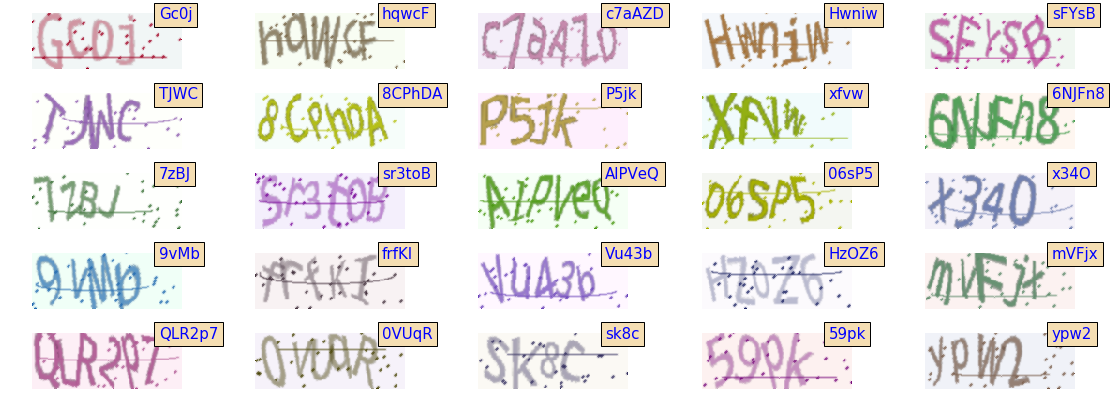

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt 

def draw_data(img,y_pred):
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['font.size'] = 14

    n = 5
    fig,axs = plt.subplots(nrows=n,ncols=n,sharex=True,sharey=True,figsize=(16,6))
    for i in range(n**2):
        ax = axs[i // n, i % n]
        ax.imshow(img[i].astype(np.uint8))
        ax.text(135,6,vec2text(y[i]),fontsize=15,color = 'blue',
                bbox=dict(boxstyle="square",facecolor='wheat'))
        ax.axis('off')
    plt.tight_layout()
    #fig.savefig(address_predict, dpi=300)
    plt.show()
    
[img,x,y] = Generate_Data().test()
draw_data(img,y)

In [4]:
import keras

class MyCbk(keras.callbacks.Callback):
    # for multi-gpu
    def __init__(self, model,logs={}):
        self.model_to_save = model
        self.min_loss = float('Inf')

    def on_epoch_end(self, epoch, logs={}):
        current_loss = logs.get('val_loss')
        if current_loss < self.min_loss:
            self.model_to_save.save(address_model)
            self.min_loss = current_loss
            print (u'val loss improved, new model saved')
        else:
            print (u'val loss does not improve in this epoch')
        

/home/cancan.zhang/ENV/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/cancan.zhang/ENV/local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


In [5]:
import keras
import numpy as np

class Evaluate(keras.callbacks.Callback):
    
    # random show a result in test set
    def __init__(self,val):
        self.x = val[1]
        self.y = val[2]
        
        
    def on_epoch_end(self,epoch,logs={}):
        
        self.random_index = np.random.randint(self.y.shape[0])
        y_pred = self.model.predict(self.x)
        y_pred = np.reshape(y_pred,[y_pred.shape[0],-1])
        self.y = np.reshape(self.y,[self.y.shape[0],-1])
        true = vec2text(self.y[self.random_index,:])
        pred = pred2text(y_pred[self.random_index,:])
        print ('True: ',true)
        print ('Pred: ',pred)

In [38]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, LSTM,GRU, Bidirectional, Dropout, Flatten, Wrapper, Activation, TimeDistributed
from keras.layers import Reshape, Lambda, RepeatVector, Concatenate, Permute, Dot, Multiply, Permute,merge,BatchNormalization 
from keras.models import Model
from keras import backend as K
from keras.engine import InputSpec
from keras import initializers, regularizers, constraints

from numpy.random import seed 
seed(1000)
from tensorflow import set_random_seed
set_random_seed(1000)


def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    time_steps = int(inputs.shape[1])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

def cnn_lstm_attention_model():
    
    [char_len,char_num] = get_char_length_and_number()  
    conv_filters = CONV_FILTERS
    kernel_size = (KERNEL_SIZE, KERNEL_SIZE)
    pool_size = POOL_SIZE
    
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL)

    input_data = Input(name='the_input',shape=input_shape,dtype='float32') # None, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL 
          
    inner = input_data
    for i in range(0,NUM_CNN_LAYERS):
        inner = Conv2D(conv_filters,
                       kernel_size,
                       padding='same',
                       activation = None, 
                       kernel_initializer='he_normal',
                       name=('conv'+str(i+1)))(inner)
        inner = BatchNormalization(name=('cnn_norm'+str(i+1)))(inner)
        inner = Activation('relu',name=('cnn_relu'+str(i+1)))(inner)
        inner = MaxPooling2D(pool_size=(pool_size, pool_size), name=('max'+str(i+1)))(inner)
       
    conv_to_rnn_dims = (IMAGE_WIDTH // (POOL_SIZE ** NUM_CNN_LAYERS), 
                        (IMAGE_HEIGHT // (POOL_SIZE ** NUM_CNN_LAYERS)) * CONV_FILTERS)
    
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner) # (None, 10, 96) 
    inner = Permute((2,1))(inner) # (None,96,10)
    inner = Dense(MAX_CHAR_LEN)(inner) # (None,96,6)
    inner = Permute((2,1))(inner) # (None,6,96)
    
    inner = Dropout(DROPOUT_RATE)(inner)
    attention_mul = attention_3d_block(inner)
    
    inner = Bidirectional(GRU(GRU_SIZE,return_sequences=True,dropout=0.25,recurrent_dropout=0.1), name='gru1')(attention_mul)
    inner = BatchNormalization(name=('gru_norm1'))(inner)
    inner = Bidirectional(GRU(GRU_SIZE,return_sequences=True,dropout=0.25,recurrent_dropout=0.1), name='gru2')(inner)
    inner = BatchNormalization(name=('gru_norm2'))(inner)
    
    outputs = TimeDistributed(Dense(char_num,activation='sigmoid'),name='dense')(inner)   
    
    Model(inputs=input_data, outputs=outputs).summary()
    model = Model(inputs=input_data, outputs=outputs)
    
    return model

In [49]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.utils import multi_gpu_model

import os
import datetime

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "11,12"

def accuracy(y_true, y_pred):
    [char_len,char_num] = get_char_length_and_number()    
    y_true = K.reshape(y_true,[-1,char_len,char_num])
    y_pred = K.reshape(y_pred,[-1,char_len,char_num])

    class_true = K.argmax(y_true,axis=2)
    class_pred = K.argmax(y_pred,axis=2)
    
    correct_pred = K.cast(K.equal(class_true,class_pred),tf.int32)
    correct_pred = K.sum(correct_pred,axis=1) # for each position
    correct_pred = K.cast(K.equal(correct_pred,char_len),tf.int32)
    correct_pred = K.cast(K.sum(correct_pred),tf.float32)
    
    accuracy = correct_pred / K.cast(tf.shape(y_true)[0],tf.float32)
    return accuracy


img_gen = Generate_Data(train_num = 128*6)
[char_len,char_num] = get_char_length_and_number()  

input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL)
model = cnn_lstm_attention_model()

parallel_model = multi_gpu_model(model, 2)
adam = keras.optimizers.Adam(lr = 0.05)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[accuracy,categorical_accuracy,categorical_crossentropy])
cbk = MyCbk(model)
tensorboard = TensorBoard(log_dir=address_tensorboard,histogram_freq=0)
eva = Evaluate(img_gen.test())
moniter = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', cooldown=3, verbose=1)

/home/cancan.zhang/ENV/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 160, 60, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 60, 32)  320         the_input[0][0]                  
__________________________________________________________________________________________________
cnn_norm1 (BatchNormalization)  (None, 160, 60, 32)  128         conv1[0][0]                      
__________________________________________________________________________________________________
cnn_relu1 (Activation)          (None, 160, 60, 32)  0           cnn_norm1[0][0]                  
__________________________________________________________________________________________________
max1 (MaxP

In [50]:
hists = []
hist = parallel_model.fit_generator(generator=img_gen.next_train(),
                    steps_per_epoch = 200,
                    epochs = 16,
                    validation_data = img_gen.next_val(),
                    validation_steps = 1,
                    verbose = 1,
                    callbacks = [cbk,eva,moniter,tensorboard])
hists.append(hist)

Epoch 1/16
200/200 [==============================] - 826s 4s/step - loss: 3.1568 - accuracy: 8.6589e-04 - categorical_accuracy: 0.2254 - categorical_crossentropy: 3.1568 - val_loss: 5.0749 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.2305 - val_categorical_crossentropy: 5.0749
val loss improved, new model saved
('True: ', '9eUjmW')
('Pred: ', 'j9JjN')
Epoch 2/16
200/200 [==============================] - 815s 4s/step - loss: 1.1681 - accuracy: 0.0983 - categorical_accuracy: 0.6300 - categorical_crossentropy: 1.1681 - val_loss: 1.3619 - val_accuracy: 0.1172 - val_categorical_accuracy: 0.6237 - val_categorical_crossentropy: 1.3619
val loss improved, new model saved
('True: ', 'nYXz')
('Pred: ', 'nYxz')
Epoch 3/16
200/200 [==============================] - 818s 4s/step - loss: 0.7680 - accuracy: 0.2307 - categorical_accuracy: 0.7589 - categorical_crossentropy: 0.7680 - val_loss: 1.2874 - val_accuracy: 0.1016 - val_categorical_accuracy: 0.6562 - val_categorical_crossentropy: 1

In [56]:
hist = parallel_model.fit_generator(generator=img_gen.next_train(),
                    steps_per_epoch = 200,
                    epochs = 16,
                    validation_data = img_gen.next_val(),
                    validation_steps = 1,
                    verbose = 1,
                    callbacks = [cbk,eva,moniter,tensorboard])
hists.append(hist)

Epoch 1/16
200/200 [==============================] - 865s 4s/step - loss: 0.4004 - accuracy: 0.4725 - categorical_accuracy: 0.8715 - categorical_crossentropy: 0.4004 - val_loss: 0.2689 - val_accuracy: 0.5859 - val_categorical_accuracy: 0.9076 - val_categorical_crossentropy: 0.2689
val loss improved, new model saved
('True: ', '5LOPPF')
('Pred: ', '5L0PPF')
Epoch 2/16
200/200 [==============================] - 871s 4s/step - loss: 0.4007 - accuracy: 0.4714 - categorical_accuracy: 0.8714 - categorical_crossentropy: 0.4007 - val_loss: 0.3599 - val_accuracy: 0.5469 - val_categorical_accuracy: 0.8932 - val_categorical_crossentropy: 0.3599
val loss does not improve in this epoch
('True: ', 'xRYDF')
('Pred: ', 'xRYDF')
Epoch 3/16
200/200 [==============================] - 871s 4s/step - loss: 0.3992 - accuracy: 0.4752 - categorical_accuracy: 0.8718 - categorical_crossentropy: 0.3992 - val_loss: 0.8502 - val_accuracy: 0.3203 - val_categorical_accuracy: 0.7956 - val_categorical_crossentropy: 0

In [57]:
hist = parallel_model.fit_generator(generator=img_gen.next_train(),
                    steps_per_epoch = 200,
                    epochs = 16,
                    validation_data = img_gen.next_val(),
                    validation_steps = 1,
                    verbose = 1,
                    callbacks = [cbk,eva,moniter,tensorboard])
hists.append(hist)

Epoch 1/16
200/200 [==============================] - 900s 4s/step - loss: 0.3379 - accuracy: 0.5264 - categorical_accuracy: 0.8897 - categorical_crossentropy: 0.3379 - val_loss: 0.1592 - val_accuracy: 0.7188 - val_categorical_accuracy: 0.9375 - val_categorical_crossentropy: 0.1592
val loss improved, new model saved
('True: ', 'edxPGA')
('Pred: ', 'edxPGA')
Epoch 2/16
200/200 [==============================] - 902s 5s/step - loss: 0.3369 - accuracy: 0.5273 - categorical_accuracy: 0.8901 - categorical_crossentropy: 0.3369 - val_loss: 0.2439 - val_accuracy: 0.5781 - val_categorical_accuracy: 0.9102 - val_categorical_crossentropy: 0.2439
val loss does not improve in this epoch
('True: ', 'kKxqRC')
('Pred: ', 'kKXqRC')
Epoch 3/16
200/200 [==============================] - 904s 5s/step - loss: 0.3350 - accuracy: 0.5288 - categorical_accuracy: 0.8907 - categorical_crossentropy: 0.3350 - val_loss: 0.1923 - val_accuracy: 0.6953 - val_categorical_accuracy: 0.9362 - val_categorical_crossentropy:

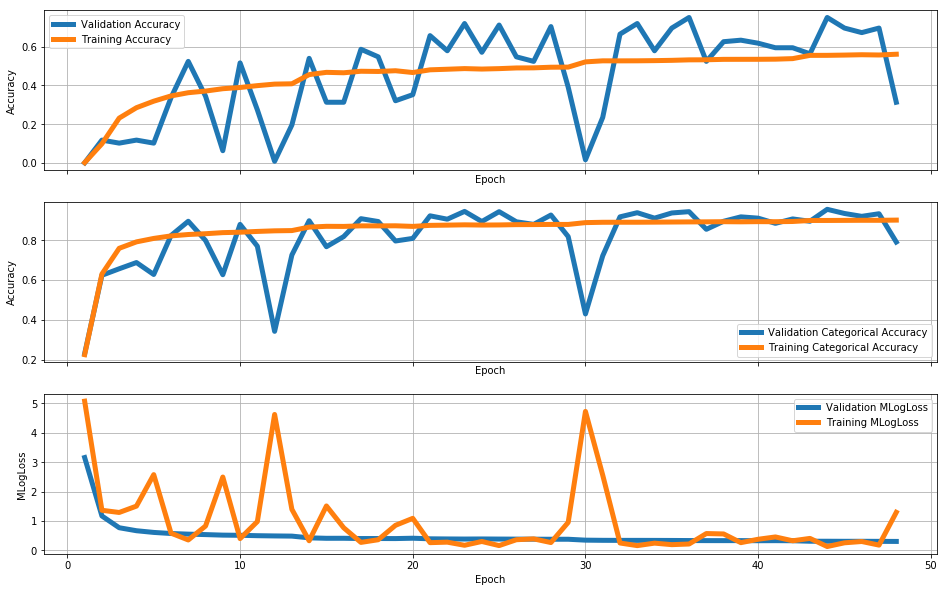

In [58]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt 

hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists])
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Categorical Accuracy')
axs[1].plot(hist_df.categorical_accuracy, lw=5, label='Training Categorical Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)

axs[2].plot(hist_df.categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[2].plot(hist_df.val_categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[2].set_ylabel('MLogLoss')
axs[2].set_xlabel('Epoch')
axs[2].grid()
axs[2].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

/home/cancan.zhang/ENV/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 160, 60, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 60, 32)  320         the_input[0][0]                  
__________________________________________________________________________________________________
cnn_norm1 (BatchNormalization)  (None, 160, 60, 32)  128         conv1[0][0]                      
__________________________________________________________________________________________________
cnn_relu1 (Activation)          (None, 160, 60, 32)  0           cnn_norm1[0][0]                  
__________________________________________________________________________________________________
max1 (MaxP

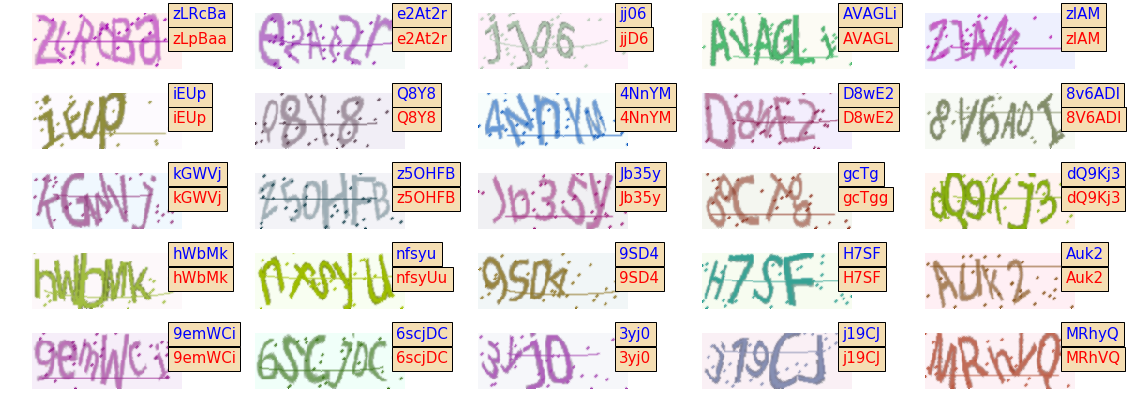

In [83]:
def draw_predict(img,y_pred):
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['font.size'] = 14

    n = 5
    fig,axs = plt.subplots(nrows=n,ncols=n,sharex=True,sharey=True,figsize=(16,6))
    for i in range(n**2):
        ax = axs[i // n, i % n]
        ax.imshow(img[i].astype(np.uint8))
        ax.text(150,6,draw_vec2text(y[i]),fontsize=15,color = 'blue',
                bbox=dict(boxstyle="square",facecolor='wheat'))
        ax.text(150,32,pred2text(y_pred[i]),fontsize=15,color = 'red',
                bbox=dict(boxstyle="square",facecolor='wheat'))
        
        ax.axis('off')
    plt.tight_layout()
    #fig.savefig(address_predict, dpi=300)
    plt.show()
    
model = cnn_lstm_attention_model()
model.load_weights(address_model)
[img,x,y] = Generate_Data().test()
y_pred = model.predict(x)
draw_predict(img,y_pred)